In [11]:
import random
import time
import matplotlib.pyplot as plt

In [12]:
class City:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.city_grid = [[1] * width for _ in range(height)]
        self.bus_stops = []

    def disconnect_road(self, road):
        x_start, y_start = road[0]
        x_end, y_end = road[1]
        self.city_grid[x_start][y_start] = 0
        self.city_grid[x_end][y_end] = 0

    def repair_road(self, road):
        x_start, y_start = road[0]
        x_end, y_end = road[1]
        self.city_grid[x_start][y_start] = 1
        self.city_grid[x_end][y_end] = 1

In [13]:
class BusStop:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.passengers_waiting = []

    def add_passenger(self, passenger):
        self.passengers_waiting.append(passenger)

    def remove_passenger(self, passenger):
        self.passengers_waiting.remove(passenger)

    def board_passengers(self, vehicle, capacity):
        boarding_passengers = self.passengers_waiting[:capacity]
        for passenger in boarding_passengers:
            vehicle.board_passenger(passenger)
            self.remove_passenger(passenger)

    def disembark_passengers(self, vehicle):
        passengers_to_disembark = [passenger for passenger in vehicle.passengers_on_board if passenger.destination == (self.x, self.y)]
        for passenger in passengers_to_disembark:
            vehicle.disembark_passenger(passenger)

    def disembark_passengers_from_vehicles(self, vehicles):
        for vehicle in vehicles:
            self.disembark_passengers(vehicle)

In [14]:
class Passenger:
    def __init__(self, origin, destination):
        self.origin = origin
        self.destination = destination
        self.current_location = origin
        self.transport_mode = "walking"
        self.waiting_for_bus = False

    def has_arrived(self):
        return self.current_location == self.destination

    def move(self, city, bus_stops, vehicles):
        if self.has_arrived() or self.waiting_for_bus:
            return

        if self.transport_mode == "walking":
            self.walk(city, bus_stops)
        elif self.transport_mode == "bus":
            self.take_bus(city, bus_stops, vehicles)

    def walk(self, city, bus_stops):
        possible_moves = self.get_possible_moves(city)
        new_location = random.choice(possible_moves)
        self.current_location = new_location

        if not self.has_arrived() and self.should_switch_to_bus():
            self.transport_mode = "bus"
            self.decide_bus_stop(bus_stops)

    def take_bus(self, city, bus_stops, vehicles):
        if self.at_bus_stop(bus_stops):
            self.board_bus(bus_stops, vehicles)
        else:
            possible_moves = self.get_possible_moves(city)
            self.current_location = random.choice(possible_moves)

    def decide_bus_stop(self, bus_stops):
        nearest_bus_stop = min(bus_stops, key=lambda stop: self.distance_to_stop(stop))
        self.destination = (nearest_bus_stop.x, nearest_bus_stop.y)

    def at_bus_stop(self, bus_stops):
        return any(self.current_location == (stop.x, stop.y) for stop in bus_stops)

    def board_bus(self, bus_stops, vehicles):
        bus_stop = next(stop for stop in bus_stops if self.current_location == (stop.x, stop.y))
        bus = next((vehicle for vehicle in vehicles if vehicle.current_location == (bus_stop.x, bus_stop.y)), None)

        if bus and len(bus.passengers_on_board) < bus.capacity:
            bus_stop.remove_passenger(self)
            bus.board_passenger(self)
            print(f"Passenger boarded {bus.name} at {bus_stop.x, bus_stop.y}")
            self.waiting_for_bus = False
        else:
            self.waiting_for_bus = True
            print(f"Passenger waiting for bus at {bus_stop.x, bus_stop.y}")

    def should_switch_to_bus(self):
        return random.random() < 0.2

    def get_possible_moves(self, city):
        dx = self.destination[0] - self.current_location[0]
        dy = self.destination[1] - self.current_location[1]

        possible_moves = []

        if dx > 0:
            possible_moves.append((self.current_location[0] + 1, self.current_location[1]))
        elif dx < 0:
            possible_moves.append((self.current_location[0] - 1, self.current_location[1]))

        if dy > 0:
            possible_moves.append((self.current_location[0], self.current_location[1] + 1))
        elif dy < 0:
            possible_moves.append((self.current_location[0], self.current_location[1] - 1))

        return [(move[0], move[1]) for move in possible_moves if 0 <= move[0] < city.width and 0 <= move[1] < city.height]

    def distance_to_stop(self, bus_stop):
        return abs(bus_stop.x - self.current_location[0]) + abs(bus_stop.y - self.current_location[1])


In [30]:
class PublicTransportVehicle:
    def __init__(self, name, route, timetable, capacity, initial_location):
        self.name = name
        self.route = route
        self.timetable = timetable
        self.capacity = capacity
        self.current_location = initial_location
        self.broken_down = False
        self.passengers_on_board = []

    def move(self, city, bus_stops):
        if not self.current_location or self.broken_down:
            return

        current_point_index = self.get_current_point_index()
        next_point_index = (current_point_index + 1) % len(self.route)

        current_point = self.route[current_point_index]
        next_point = self.route[next_point_index]

        path = self.shortest_path(self.current_location, next_point, city)
        if path:
            self.current_location = path[1]

        if self.current_location == self.route[-1]:
            time.sleep(2)
            self.route.reverse()

        self.check_for_disembarkation(bus_stops)
        self.check_for_boarding(bus_stops)

    def get_current_point_index(self):
        try:
            return self.route.index(self.current_location)
        except ValueError:
            return -1

    def break_down(self):
        self.broken_down = True

    def repair(self):
        if self.broken_down:
            self.broken_down = False
            print(f"{self.name} has been repaired and is back in service at {self.route[0]}")

    def board_passenger(self, passenger):
        self.passengers_on_board.append(passenger)

    def disembark_passenger(self, passenger):
        self.passengers_on_board.remove(passenger)

    def check_for_disembarkation(self, bus_stops):
        for bus_stop in bus_stops:
            if self.current_location == (bus_stop.x, bus_stop.y):
                passengers_to_disembark = [passenger for passenger in self.passengers_on_board if passenger.destination == (bus_stop.x, bus_stop.y)]
                for passenger in passengers_to_disembark:
                    self.disembark_passenger(passenger)
                    print(f"Passenger disembarked from {self.name} at {bus_stop.x, bus_stop.y}")
                    if passenger.has_arrived():
                        print(f"Passenger at {passenger.current_location} has arrived at the destination")

    def check_for_boarding(self, bus_stops):
        for bus_stop in bus_stops:
            if self.current_location == (bus_stop.x, bus_stop.y):
                bus_stop.board_passengers(self, self.capacity)
                if bus_stop.passengers_waiting:
                    print(f"{self.name} at {self.current_location}: Passengers boarded the bus")
                else:
                    print(f"{self.name} at {self.current_location}: No passengers to board")


    def shortest_path(self, start, end, city):
        visited = set()
        queue = [[start]]

        if start == end:
            return [start]

        while queue:
            path = queue.pop(0)
            node = path[-1]

            if node not in visited:
                neighbors = self.get_neighbors(node, city)
                for neighbor in neighbors:
                    new_path = list(path)
                    new_path.append(neighbor)
                    queue.append(new_path)

                    if neighbor == end:
                        return new_path

                visited.add(node)

    def get_neighbors(self, node, city):
      neighbors = []

      if isinstance(node, BusStop):
          x, y = node.x, node.y
          if x > 0 and city.city_grid[x-1][y] == 1:
              neighbors.append((x-1, y))
          if x < city.width - 1 and city.city_grid[x+1][y] == 1:
              neighbors.append((x+1, y))
          if y > 0 and city.city_grid[x][y-1] == 1:
              neighbors.append((x, y-1))
          if y < city.height - 1 and city.city_grid[x][y+1] == 1:
              neighbors.append((x, y+1))
      else:
          x, y = node
          if x > 0 and city.city_grid[x-1][y] == 1:
              neighbors.append((x-1, y))
          if x < city.width - 1 and city.city_grid[x+1][y] == 1:
              neighbors.append((x+1, y))
          if y > 0 and city.city_grid[x][y-1] == 1:
              neighbors.append((x, y-1))
          if y < city.height - 1 and city.city_grid[x][y+1] == 1:
              neighbors.append((x, y+1))

      return neighbors

    def __str__(self):
        return f"{self.name} at {self.current_location}, Capacity: {len(self.passengers_on_board)}/{self.capacity}, Broken Down: {self.broken_down}"

In [57]:
class CitySimulation:
    def __init__(self, city, bus_stops):
        self.city = city
        self.passengers = []
        self.vehicles = []
        self.bus_stops = bus_stops
        self.disturbance_time = None
        self.simulation_states = []
        self.pedestrian_paths = []

    def add_passenger(self, passenger):
        self.passengers.append(passenger)

    def add_vehicle(self, vehicle):
        self.vehicles.append(vehicle)

    def place_vehicles(self):
        for vehicle in self.vehicles:
            vehicle.current_location = vehicle.route[0].x, vehicle.route[0].y


    def all_passengers_arrived(self):
        return all(passenger.has_arrived() for passenger in self.passengers)


    def add_simulation_state(self):
      state = {
          "passengers": [(p.current_location, p.destination, p.transport_mode) for p in self.passengers],
          "vehicles": [(v.name, v.current_location, len(v.passengers_on_board), v.broken_down) for v in self.vehicles],
          "bus_stops": [(bs.x, bs.y, [p.current_location for p in bs.passengers_waiting]) for bs in self.bus_stops],
          "disturbance_time": self.disturbance_time,
          "bus_locations": [(v.current_location[0], v.current_location[1]) for v in self.vehicles]  # Add this line
      }
      self.simulation_states.append(state)


    def simulate(self, duration=30):
        self.place_vehicles()
        start_time = time.time()
        while time.time() - start_time < duration and not self.all_passengers_arrived():
            print("\nSimulation Time:", int(time.time() - start_time), "seconds")
            self.add_simulation_state()
            self.check_for_disturbance()

            for passenger in self.passengers:
                passenger.move(self.city, self.bus_stops, self.vehicles)

            for vehicle in self.vehicles:
                vehicle.move(self.city, self.bus_stops)

            for bus_stop in self.bus_stops:
                bus_stop.disembark_passengers_from_vehicles(self.vehicles)

            for passenger in self.passengers:
                print(f"Passenger at {passenger.current_location}, Destination: {passenger.destination}, Mode: {passenger.transport_mode}")

            for vehicle in self.vehicles:
                print(vehicle)

            time.sleep(1)

            # Check for disturbance only if no ongoing disturbance
            if self.disturbance_time is None:
                self.check_for_disturbance()

            # Repair disturbance if it has been ongoing for more than 3 seconds
            if self.disturbance_time is not None and time.time() - self.disturbance_time > 3:
                print("Repairing disturbance...")
                self.repair_disturbance()

    def disconnect_road(self, road):
        x_start, y_start = road[0]
        x_end, y_end = road[1]
        self.city_grid[x_start][y_start] = 0
        self.city_grid[x_end][y_end] = 0

    def repair_road(self, road):
        x_start, y_start = road[0]
        x_end, y_end = road[1]
        self.city_grid[x_start][y_start] = 1
        self.city_grid[x_end][y_end] = 1

    def plot_simulation(self, step):
        fig, ax = plt.subplots()

        for i in range(self.city.width):
          for j in range(self.city.height):
              if (i, j) in self.city.bus_stops:
                  ax.plot(i, j, 's', markersize=8, color='blue', markeredgecolor='black')  # Blue square for bus stops
              elif self.city.city_grid[i][j] == 0:
                  ax.plot(i, j, 'x', markersize=8, color='red')  # Red Cross for disturbance
              else:
                  ax.plot(i, j, 'o', markersize=6, color='gray')  # Gray Circle for roads

        # Plot passengers
        for passenger in self.simulation_states[step]["passengers"]:
            ax.plot(passenger[0][0], passenger[0][1], 'o', markersize=8, color='purple')  # Purple circle for passengers

        # Plot vehicles
        for vehicle in self.simulation_states[step]["vehicles"]:
            if vehicle[3]:
                ax.plot(vehicle[1][0], vehicle[1][1], 's', markersize=8, color='black')  # Black square for broken-down vehicles
            else:
                ax.plot(vehicle[1][0], vehicle[1][1], 'v', markersize=8, color='yellow')  # Yellow triangle for operational vehicles

        # Plot bus stops with waiting passengers
        for bus_stop in self.simulation_states[step]["bus_stops"]:
            ax.plot(bus_stop[0], bus_stop[1], 's', markersize=8, color='blue', markeredgecolor='black')  # Blue square for bus stops
            for passenger_position in bus_stop[2]:
                ax.plot(passenger_position[0], passenger_position[1], 'o', markersize=8, color='purple')  # Purple circle for waiting passengers


        print(f"Step: {step}")
        print("Passengers:", self.simulation_states[step]["passengers"])
        print("Vehicles:", self.simulation_states[step]["vehicles"])
        print("Bus Stops:", self.simulation_states[step]["bus_stops"])

        plt.title(f'Simulation Step: {step}')
        plt.grid(True)
        plt.show()

    def check_for_disturbance(self):
        if random.random() < 0.5:
            self.introduce_disturbance()

    def repair_disturbance(self):
        for vehicle in self.vehicles:
            if vehicle.broken_down:
                vehicle.repair()
                vehicle.current_location = vehicle.route[0]

        # Reset the disturbance time after repairing
        self.disturbance_time = None

    def introduce_disturbance(self):
        disturbance_type = random.choice(["road_disconnection", "vehicle_breakdown"])

        if disturbance_type == "road_disconnection":
            road_to_disconnect = random.choice(self.get_all_roads())
            self.city.disconnect_road(road_to_disconnect)
            print("Road disconnected:", road_to_disconnect)
        elif disturbance_type == "vehicle_breakdown":
            operational_vehicles = [vehicle for vehicle in self.vehicles if not vehicle.broken_down]
            if operational_vehicles:
                vehicle_to_breakdown = random.choice(operational_vehicles)
                vehicle_to_breakdown.break_down()
                print(f"Vehicle breakdown: {vehicle_to_breakdown.name} at {vehicle_to_breakdown.current_location}")

        self.disturbance_time = time.time()

    def get_all_roads(self):
        roads = []
        for i in range(self.city.width - 1):
            for j in range(self.city.height):
                roads.append(((i, j), (i + 1, j)))

        for i in range(self.city.width):
            for j in range(self.city.height - 1):
                roads.append(((i, j), (i, j + 1)))

        return roads


In [58]:
# Use Case
city = City(width=10, height=10)

bus_stop1 = BusStop(3, 3)
bus_stop2 = BusStop(6, 6)
bus_stop3 = BusStop(1, 8)

bus_stop4 = BusStop(2, 3)
bus_stop5 = BusStop(5, 4)
bus_stop6 = BusStop(7, 8)
bus_stops = [bus_stop1, bus_stop2, bus_stop3, bus_stop4, bus_stop5, bus_stop6]

city.bus_stops.extend(bus_stops)

passenger1 = Passenger((4, 1), (8, 8))
passenger2 = Passenger((3, 2), (7, 6))
passenger3 = Passenger((0, 0), (6, 6))

vehicle1 = PublicTransportVehicle(name="Bus1", route=[bus_stop1, bus_stop2, bus_stop3], timetable=[(0, 10), (15, 25)], capacity=5, initial_location=(0, 0))
vehicle2 = PublicTransportVehicle(name="Bus2", route=[bus_stop4, bus_stop5, bus_stop6], timetable=[(5, 15), (20, 30)], capacity=3, initial_location=(5, 5))

simulation = CitySimulation(city, bus_stops)
simulation.add_passenger(passenger1)
simulation.add_passenger(passenger2)
simulation.add_passenger(passenger3)
simulation.add_vehicle(vehicle1)
simulation.add_vehicle(vehicle2)

print("Bus Stops:")
for bus_stop in bus_stops:
    print(f"({bus_stop.x}, {bus_stop.y})")

simulation.simulate(duration=30)

Bus Stops:
(3, 3)
(6, 6)
(1, 8)
(2, 3)
(5, 4)
(7, 8)

Simulation Time: 0 seconds
Bus1 at (3, 3): No passengers to board
Bus2 at (2, 3): No passengers to board
Passenger at (4, 2), Destination: (3, 3), Mode: bus
Passenger at (4, 2), Destination: (7, 6), Mode: walking
Passenger at (0, 1), Destination: (6, 6), Mode: walking
Bus1 at (3, 3), Capacity: 0/5, Broken Down: False
Bus2 at (2, 3), Capacity: 0/3, Broken Down: False

Simulation Time: 1 seconds
Road disconnected: ((5, 5), (5, 6))
Bus1 at (3, 3): No passengers to board
Bus2 at (2, 3): No passengers to board
Passenger at (4, 3), Destination: (3, 3), Mode: bus
Passenger at (4, 3), Destination: (7, 6), Mode: walking
Passenger at (1, 1), Destination: (6, 6), Mode: walking
Bus1 at (3, 3), Capacity: 0/5, Broken Down: False
Bus2 at (2, 3), Capacity: 0/3, Broken Down: False

Simulation Time: 2 seconds
Bus1 at (3, 3): No passengers to board
Bus2 at (2, 3): No passengers to board
Passenger at (3, 3), Destination: (3, 3), Mode: bus
Passenger at 

Step: 0
Passengers: [((4, 1), (8, 8), 'walking'), ((3, 2), (7, 6), 'walking'), ((0, 0), (6, 6), 'walking')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, False)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


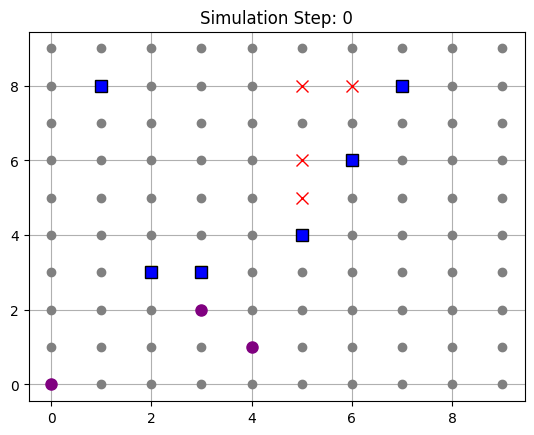

Step: 1
Passengers: [((4, 2), (3, 3), 'bus'), ((4, 2), (7, 6), 'walking'), ((0, 1), (6, 6), 'walking')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, False)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


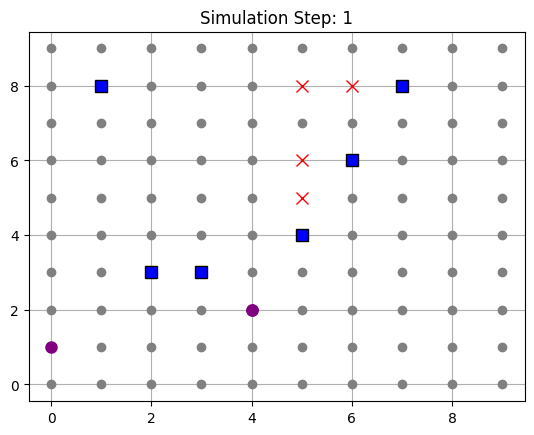

Step: 2
Passengers: [((4, 3), (3, 3), 'bus'), ((4, 3), (7, 6), 'walking'), ((1, 1), (6, 6), 'walking')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, False)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


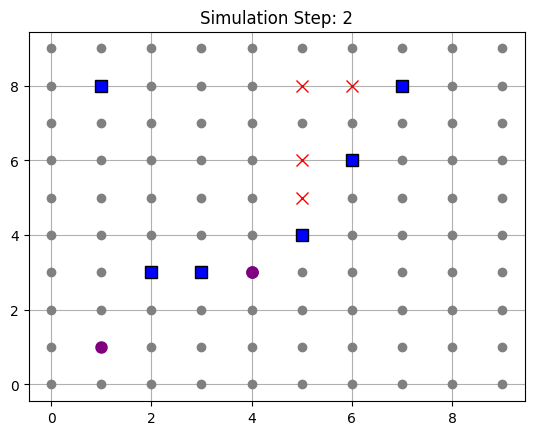

Step: 3
Passengers: [((3, 3), (3, 3), 'bus'), ((5, 3), (7, 6), 'walking'), ((1, 2), (6, 6), 'walking')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, False)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


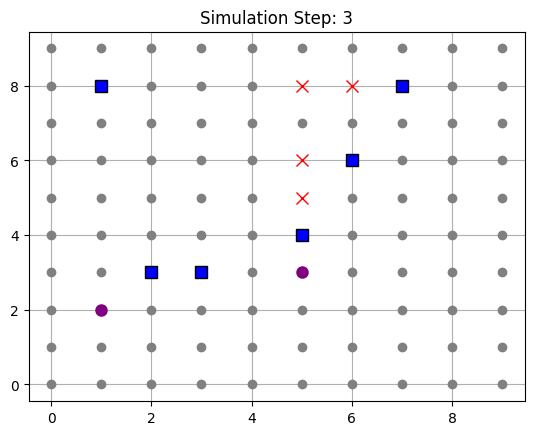

Step: 4
Passengers: [((3, 3), (3, 3), 'bus'), ((6, 3), (7, 6), 'walking'), ((2, 2), (2, 3), 'bus')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, False)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


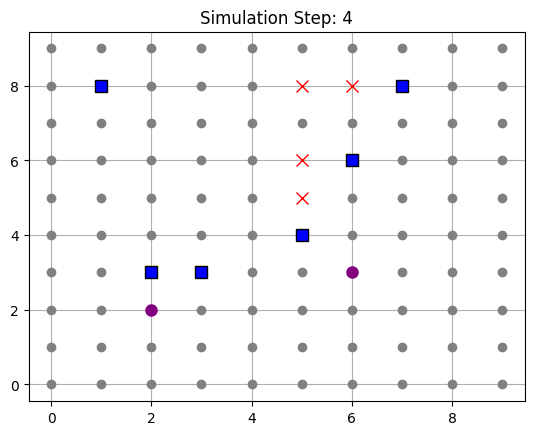

Step: 5
Passengers: [((3, 3), (3, 3), 'bus'), ((6, 4), (7, 6), 'walking'), ((2, 3), (2, 3), 'bus')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, False)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


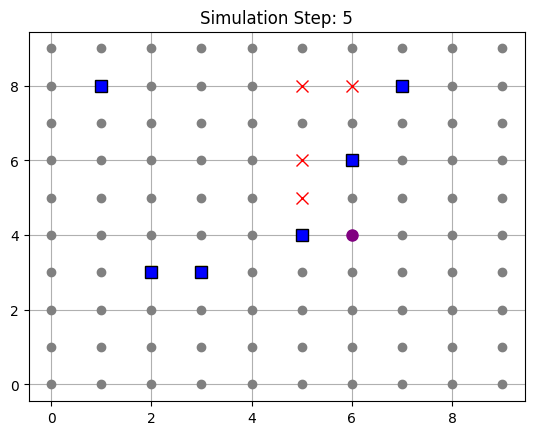

Step: 6
Passengers: [((3, 3), (3, 3), 'bus'), ((7, 4), (7, 6), 'walking'), ((2, 3), (2, 3), 'bus')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, False)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


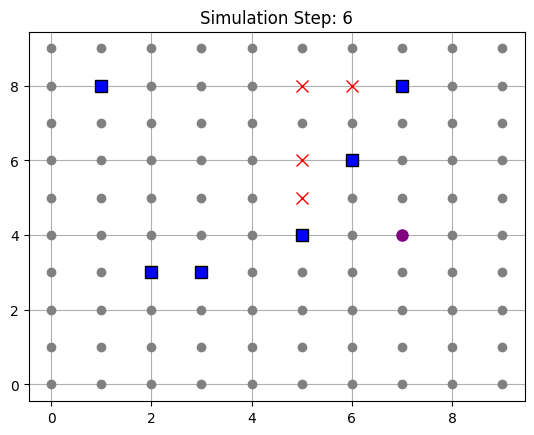

Step: 7
Passengers: [((3, 3), (3, 3), 'bus'), ((7, 5), (7, 6), 'walking'), ((2, 3), (2, 3), 'bus')]
Vehicles: [('Bus1', (3, 3), 0, False), ('Bus2', (2, 3), 0, True)]
Bus Stops: [(3, 3, []), (6, 6, []), (1, 8, []), (2, 3, []), (5, 4, []), (7, 8, [])]


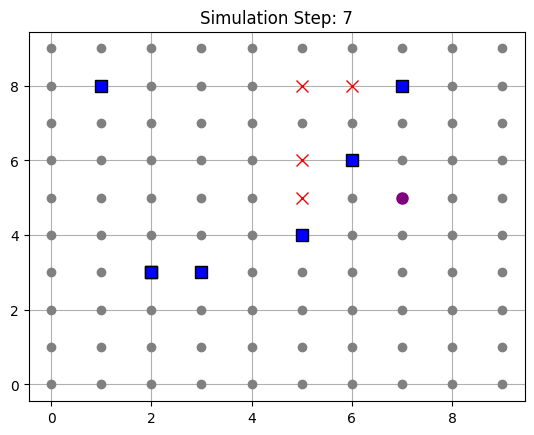

In [59]:
# Plot each step of the simulation using animation
for step in range(len(simulation.simulation_states)):
    simulation.plot_simulation(step)